# Name: Youssef Mohamed Azmy         ID: 211004285

Link: https://colab.research.google.com/drive/1lyKLW4HacjbOmQesSR-idwj6F34nxq3D?usp=sharing

In [2]:
!pip install -q transformers accelerate datasets scikit-learn matplotlib torch

import os, re, random, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, pipeline
)

In [3]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/Dataset.tsv"
df = pd.read_csv(DATA_PATH, sep="\t")

Mounted at /content/drive


In [5]:
if {"label","text"}.issubset(df.columns) is False:
    raise ValueError("Dataset must contain 'label' and 'text' columns.")

def clean_text(text: str) -> str:
    return re.sub(r"[?&#$%@*^]", "", str(text))

df["text"] = df["text"].apply(clean_text)

In [6]:
_label_norm_map = {
    "positive":"Positive", "pos":"Positive", "posotive":"Positive", "positve":"Positive",
    "negative":"Negative", "neg":"Negative",
    "neutral":"Mixed", "mix":"Mixed", "mixed":"Mixed", "middle":"Mixed"
}
def normalize_label(x):
    s = str(x).strip()
    low = s.lower()
    return _label_norm_map.get(low, s)

df["label"] = df["label"].apply(normalize_label)

In [7]:
desired_order = ["Positive", "Mixed", "Negative"]
present = sorted(df["label"].unique().tolist())
missing = [c for c in desired_order if c not in df["label"].unique()]
if missing:
    raise ValueError(f"Dataset is missing expected classes: {missing}. Please ensure labels map to {desired_order}.")


In [8]:
train_df, test_df = train_test_split(
    df, test_size=0.30, random_state=SEED, stratify=df["label"]
)


In [9]:
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def keep_len_leq_512(df_in: pd.DataFrame) -> pd.DataFrame:
    keep_rows = []
    for _, row in df_in.iterrows():
        ids = tokenizer(row["text"], add_special_tokens=True, truncation=False)["input_ids"]
        if len(ids) <= 512:
            keep_rows.append(row)
    return pd.DataFrame(keep_rows)

train_df = keep_len_leq_512(train_df).reset_index(drop=True)


Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors


In [11]:
def encode_texts(texts):
    return tokenizer(
        list(texts), truncation=True, padding="max_length", max_length=512
    )

train_enc = encode_texts(train_df["text"])
test_enc  = encode_texts(test_df["text"])


In [12]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

In [13]:
label2id = {"Positive": 0, "Mixed": 1, "Negative": 2}
id2label = {v: k for k, v in label2id.items()}

train_labels = [label2id[x] for x in train_df["label"]]
test_labels  = [label2id[x] for x in test_df["label"]]

train_ds = TextDataset(train_enc, train_labels)
test_ds  = TextDataset(test_enc,  test_labels)


In [14]:
def largest_safe_batch(candidates=(64, 48, 32, 24, 16, 12, 8, 6, 4)):

    for bs in candidates:
        try:
            with torch.no_grad():
                sample = {k: torch.tensor(v[:bs]).to(device) for k, v in train_enc.items()}
                _ = model(**sample)
            torch.cuda.empty_cache()
            return bs
        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                torch.cuda.empty_cache()
                continue
            else:
                raise
    return 4

per_device_bs = largest_safe_batch()


In [15]:
def make_training_args():
    base = dict(
        output_dir="./results",
        num_train_epochs=2,
        per_device_train_batch_size=per_device_bs,
        per_device_eval_batch_size=per_device_bs,
        gradient_accumulation_steps=8,
        logging_dir="./logs",
        fp16=torch.cuda.is_available(),
        seed=SEED
    )
    try:
        return TrainingArguments(report_to="none", evaluation_strategy="epoch", save_strategy="epoch", **base)
    except TypeError:
        return TrainingArguments(**base)

training_args = make_training_args()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)
trainer.train()

Step,Training Loss
500,0.729400
1000,0.656700
1500,0.626800
2000,0.603100
2500,0.540900
3000,0.516800
3500,0.508000
4000,0.498100


TrainOutput(global_step=4276, training_loss=0.580023930605825, metrics={'train_runtime': 5915.1605, 'train_samples_per_second': 23.123, 'train_steps_per_second': 0.723, 'total_flos': 3.598760082316493e+16, 'train_loss': 0.580023930605825, 'epoch': 2.0})

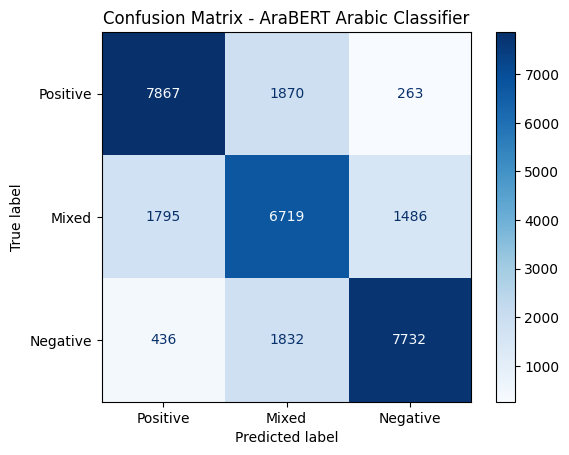

              precision    recall  f1-score   support

    Positive      0.779     0.787     0.783     10000
       Mixed      0.645     0.672     0.658     10000
    Negative      0.816     0.773     0.794     10000

    accuracy                          0.744     30000
   macro avg      0.746     0.744     0.745     30000
weighted avg      0.746     0.744     0.745     30000



In [19]:
pred = trainer.predict(test_ds)
y_true = np.array(test_labels)
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive","Mixed","Negative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - AraBERT Arabic Classifier")
plt.show()
report = classification_report(y_true, y_pred, target_names=["Positive","Mixed","Negative"], digits=3)
print(report)


In [24]:
SAVE_PATH = "/content/drive/MyDrive/fine_tuned_arabic_bert"
model.config.label2id = label2id
model.config.id2label = id2label
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

from transformers import pipeline
clf = pipeline("text-classification", model=SAVE_PATH, tokenizer=SAVE_PATH, device=0 if torch.cuda.is_available() else -1)

samples = [
    "الاكل كان جامد جدا والاسعار حلوة اوي.",
    "الخدمة كانت كويسة بس الاسعار غالية شوية.",
    "الاسعار غالية والمكان مايستاهلش خالص مش هاروح هناك تاني."
]

for s in samples:
    r = clf(s)[0]
    print(f"{s} → {r['label']} ({r['score']:.2f})")


Device set to use cuda:0


الاكل كان جامد جدا والاسعار حلوة اوي. → Positive (0.82)
الخدمة كانت كويسة بس الاسعار غالية شوية. → Mixed (0.57)
الاسعار غالية والمكان مايستاهلش خالص مش هاروح هناك تاني. → Negative (0.86)
